In [1]:
import os
import random
import numpy as np
import scipy.io
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.animation import FuncAnimation, PillowWriter
import cv2
import torchvision.transforms.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#DOF

In [3]:
def apply_dof_blur(rgb, depth, focus=0.5, focal_length=0.1, intensity=5, blur_levels=5):
    # rgb: imagen en color -> (h, w, 3)
    # depth: mapa de profundidad normalizado -> (h, w)

    h, w, _ = rgb.shape  # (h, w, 3)
    blurred_stack = []  # Lista para almacenar versiones desenfocadas de la imagen

    for i in range(blur_levels):
        sigma = i * intensity / (blur_levels - 1)
        if sigma == 0:
            blurred = rgb  # Sin desenfoque
        else:
            blurred = cv2.GaussianBlur(rgb, (0, 0), sigma)  # (h, w, 3)
        blurred_stack.append(blurred)

    blurred_stack = np.stack(blurred_stack)  # (blur_levels, h, w, 3)

    depth_diff = np.abs(depth - focus)  # (h, w)
    weights = np.clip(depth_diff / focal_length, 0, 1)  # (h, w), valores normalizados entre 0 y 1

    weights_idx = np.clip((weights * (blur_levels - 1)).astype(int), 0, blur_levels - 1)  # (h, w), índice entero de desenfoque

    final = np.zeros_like(rgb)  # (h, w, 3)

    for i in range(blur_levels):
        mask = (weights_idx == i)  # (h, w), booleano
        final[mask] = blurred_stack[i][mask]

    return final, weights  # final: (h, w, 3), weights: (h, w)

In [4]:
def animate_dof_and_weights(rgb_path, depth_path, gif_path='dof_with_weights.gif',
                             frames=30, focal_length=0.08, intensity=6, blur_levels=6):
    rgb_img = np.array(Image.open(rgb_path).convert('RGB'))

    if depth_path.endswith('.npy'):
        depth_map = np.load(depth_path)
    else:
        depth_map = np.array(Image.open(depth_path).convert('L')) / 255.0

    if depth_map.max() > 1:
        depth_map = depth_map / depth_map.max()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    img_disp = ax1.imshow(rgb_img)
    weight_disp = ax2.imshow(np.zeros_like(depth_map), cmap='magma', vmin=0, vmax=1)
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title("DoF Effect")
    ax2.set_title("Blur Weights")

    def update(frame):
        focus = frame / (frames - 1)
        dof_img, weights = apply_dof_blur(
            rgb=rgb_img,
            depth=depth_map,
            focus=focus,
            focal_length=focal_length,
            intensity=intensity,
            blur_levels=blur_levels
        )
        img_disp.set_data(dof_img)
        weight_disp.set_data(weights)
        ax1.set_title(f"DoF Effect\nFocus = {focus:.2f}")
        ax2.set_title("Blur Weights")
        return [img_disp, weight_disp]

    anim = FuncAnimation(fig, update, frames=frames, interval=100, blit=True)
    anim.save(gif_path, writer=PillowWriter(fps=10))
    plt.close(fig)
    print(f"Animación guardada como {gif_path}")

In [5]:
animate_dof_and_weights(
    rgb_path='/content/drive/MyDrive/Dataset/nyu_rgb/img_0111.png',
    depth_path='/content/drive/MyDrive/Dataset/nyu_depth_npy/depth_0111.npy',
    gif_path='dof_animacion_smoth.gif',
    frames=30,
    focal_length=0.4,
    intensity=6,
    blur_levels=100
)

Animación guardada como dof_animacion_smoth.gif


#DATASET

In [6]:
def generate_dof_images(
    rgb_dir, depth_dir, output_dir,
    dof_levels=4, focus_values=None,
    focal_length=0.1, intensity=5, blur_levels=5,
    npy_depth=True
):
    """Genera imágenes con diferentes niveles de DoF."""
    os.makedirs(output_dir, exist_ok=True)
    files = sorted(f for f in os.listdir(rgb_dir) if f.endswith(('.png', '.jpg')))

    if focus_values is None:
        focus_values = np.linspace(0, 1, dof_levels)

    for i in range(dof_levels):
        os.makedirs(os.path.join(output_dir, f'dof{i}'), exist_ok=True)

    for fname in tqdm(files, desc="Generando imágenes DoF"):
        img_path = os.path.join(rgb_dir, fname)
        rgb_img = np.array(Image.open(img_path).convert('RGB'))

        # Cargar mapa de profundidad
        if npy_depth:
            dname = fname.replace('img_', 'depth_').replace('.png', '') + '.npy'
            depth_path = os.path.join(depth_dir, dname)
            depth_map = np.load(depth_path)
        else:
            dname = fname.replace('img_', 'depth_')
            depth_path = os.path.join(depth_dir, dname)
            depth_map = np.array(Image.open(depth_path).convert('L')) / 255.0

        if depth_map.max() > 1:
            depth_map = depth_map / np.max(depth_map)

        for i, focus in enumerate(focus_values):
            dof_img, _ = apply_dof_blur(
                rgb_img, depth_map,
                focus=focus,
                focal_length=focal_length,
                intensity=intensity,
                blur_levels=blur_levels
            )
            out_path = os.path.join(output_dir, f'dof{i}', fname)
            Image.fromarray(dof_img).save(out_path)

In [ ]:
generate_dof_images(
    rgb_dir='/content/drive/MyDrive/Dataset/nyu_rgb',
    depth_dir='/content/drive/MyDrive/Dataset/nyu_depth_npy',
    output_dir='/content/drive/MyDrive/Dataset/nyu_rgb',
    dof_levels=5,
    focus_values=[0.0, 0.25, 0.5, 0.75, 1.0],
    focal_length=0.4,
    intensity=6,
    blur_levels=50,
    npy_depth=True
)

Generando imágenes DoF:   4%|▍         | 62/1449 [04:53<1:39:01,  4.28s/it]

#DATALOADER

In [ ]:
class NYUDataset(Dataset):
    def __init__(self,
                 rgb_dir,
                 depth_dir,
                 input_size=None,
                 dof_levels=5,
                 npy_depth=True):
        self.rgb_dir     = rgb_dir
        self.depth_dir   = depth_dir
        self.input_size  = input_size
        self.dof_levels  = dof_levels
        self.npy_depth   = npy_depth

        # Solo archivos válidos (filtramos subdirectorios como dof0/, dof1/, etc.)
        base_files = sorted([
            f for f in os.listdir(rgb_dir)
            if os.path.isfile(os.path.join(rgb_dir, f)) and f.endswith('.png')
        ])

        # Generar todas las combinaciones (imagen, dof_level)
        self.pairs = [
            (filename, dof_level)
            for filename in base_files
            for dof_level in range(dof_levels)
        ]

        if self.input_size is not None:
            self.transform = T.Compose([
                T.Resize(self.input_size),
                T.ToTensor()
            ])
        else:
            self.transform = T.ToTensor()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        name, dof = self.pairs[idx]

        # Imagen desenfocada
        dof_path = os.path.join(self.rgb_dir, f'dof{dof}', name)
        if not os.path.isfile(dof_path):
            raise FileNotFoundError(f"No se encontró la imagen desenfocada: {dof_path}")

        # Imagen original (ground truth)
        gt_path = os.path.join(self.rgb_dir, name)

        dof_img = Image.open(dof_path).convert('RGB')
        gt_img  = Image.open(gt_path).convert('RGB')

        # Cargar el mapa de profundidad
        if self.npy_depth:
            depth_arr = np.load(
                os.path.join(self.depth_dir, name.replace('img_', 'depth_').replace('.png', '') + '.npy')
            )
            depth = Image.fromarray(depth_arr)
        else:
            depth = Image.open(
                os.path.join(self.depth_dir, name.replace('img_', 'depth_'))
            )

        # Aplicar transformaciones
        dof_img = self.transform(dof_img)
        gt_img  = self.transform(gt_img)
        depth   = self.transform(depth)

        return {
            'image': dof_img,
            'gt': gt_img,
            'depth': depth,
            'dof': dof,
            'name': name
        }

In [ ]:
rgb_dir = '/content/drive/MyDrive/Dataset/nyu_rgb'
depth_dir = '/content/drive/MyDrive/Dataset/nyu_depth_npy'
dataset = NYUDataset(
    rgb_dir=rgb_dir,
    depth_dir=depth_dir,
    input_size=None,
    dof_levels=5,
    npy_depth=True
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


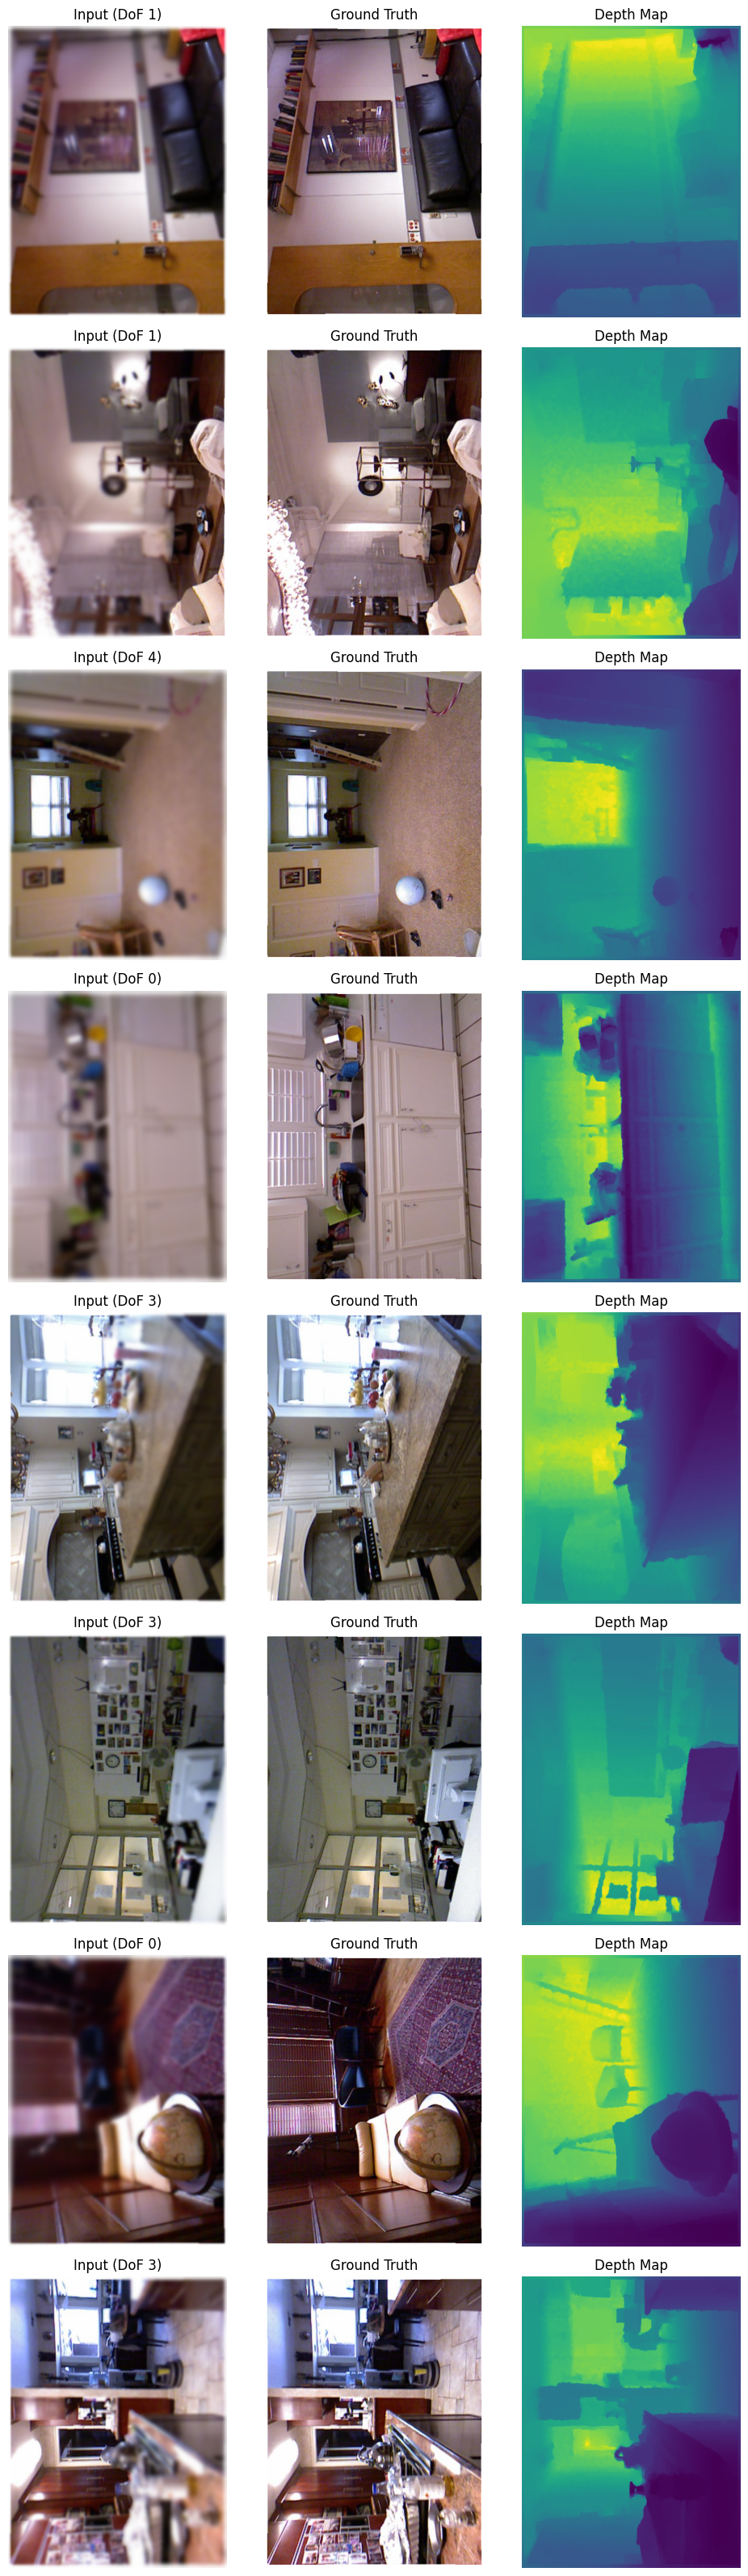

In [ ]:
def show_batch(batch, max_images=8):
    images = batch['image']
    gts    = batch['gt']
    depths = batch['depth']
    dofs   = batch['dof']

    batch_size = min(images.size(0), max_images)
    fig, axs = plt.subplots(batch_size, 3, figsize=(10, 4 * batch_size))

    for i in range(batch_size):
        img    = F.to_pil_image(images[i].cpu())
        gt     = F.to_pil_image(gts[i].cpu())
        depth  = depths[i].squeeze().cpu().numpy()
        dof    = dofs[i].item()

        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f'Input (DoF {dof})')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(gt)
        axs[i, 1].set_title('Ground Truth')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(depth, cmap='viridis')
        axs[i, 2].set_title('Depth Map')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

batch = next(iter(dataloader))
show_batch(batch)